In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random
#import cv2
import os

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Changing directory to images
os.chdir("/content/drive/MyDrive/Data Analysis Bootcamp/Resources")

In [5]:
# Check Classes 
image_names=list(os.listdir("Database"))
image_names.sort()
print(image_names)
class_number = len(image_names)

['COVID19', 'NORMAL', 'Viral_Pneumonia']


In [6]:
# Directory with Atelectasis
atele_dir=os.path.join("Database/COVID19")
df =pd.DataFrame.from_records({"file_name":os.listdir(atele_dir),"condition": "Covid"})
for f in image_names[1:]:
    folder_path="Database/" + f
    temp_df= pd.DataFrame.from_records({"file_name":os.listdir(folder_path),"condition": f })
    df=df.append(temp_df)
    
df["condition"].value_counts()

Viral_Pneumonia    1463
NORMAL             1341
Covid              1327
Name: condition, dtype: int64

In [7]:
#Exporting Label CSV
#df.to_csv("Labels.csv")

In [8]:
# balance classes - random Random Sampling No_Finding
#df_no_finding = df[df["condition"]=="No_Finding"].sample(n=150, random_state=42)
#df_balanced = df[df["condition"]!="No_Finding"].append(df_no_finding)
#df_balanced["condition"].value_counts()

In [9]:
#df_balanced["file_name"] = "Resources/Images/Classes/"+df_balanced["file_name"]

In [10]:
# Settings
batch_size = 128
img_height, img_width = 200,200
epochs = 50

In [11]:
data_dir = "Database/"

# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)

# Flow training images in batches of batch_size using train_data 
train_ds= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=True, 
                seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3)

val_ds=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=True, 
                seed=30)

Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.


Epoch 1/50
23/23 [==============================] - 850s 37s/step - loss: 1.0265 - accuracy: 0.5078 - val_loss: 0.7322 - val_accuracy: 0.8506
Epoch 2/50
23/23 [==============================] - 73s 3s/step - loss: 0.8039 - accuracy: 0.7428 - val_loss: 0.6939 - val_accuracy: 0.8611
Epoch 3/50
23/23 [==============================] - 71s 3s/step - loss: 0.7233 - accuracy: 0.8292 - val_loss: 0.6992 - val_accuracy: 0.8506
Epoch 4/50
23/23 [==============================] - 70s 3s/step - loss: 0.7266 - accuracy: 0.8241 - val_loss: 0.6612 - val_accuracy: 0.8918
Epoch 5/50
23/23 [==============================] - 70s 3s/step - loss: 0.7275 - accuracy: 0.8199 - val_loss: 0.6657 - val_accuracy: 0.8869
Epoch 6/50
23/23 [==============================] - 69s 3s/step - loss: 0.7180 - accuracy: 0.8299 - val_loss: 0.7298 - val_accuracy: 0.8110
Epoch 7/50
23/23 [==============================] - 69s 3s/step - loss: 0.6965 - accuracy: 0.8548 - val_loss: 0.6531 - val_accuracy: 0.8974
Epoch 8/50
23/23 [

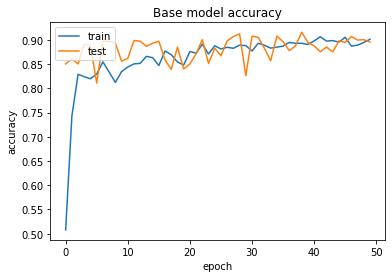

In [17]:
# Base model

with tf.device('/device:GPU:0'):
  model = tf.keras.Sequential([
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Dense(img_height, activation='relu'),
                               Flatten(),
                               Dense(class_number, activation='softmax')
                               ])
  model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
  )

  history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Base model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [23]:
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv('Base_model.csv')

tf.keras.utils.plot_model(
    model, to_file='Base_model.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

model.save('Base_model.h5')

Epoch 1/50
23/23 [==============================] - 76s 3s/step - loss: 0.8901 - accuracy: 0.7148 - val_loss: 0.7642 - val_accuracy: 0.8086
Epoch 2/50
23/23 [==============================] - 74s 3s/step - loss: 0.7014 - accuracy: 0.8832 - val_loss: 0.7130 - val_accuracy: 0.8473
Epoch 3/50
23/23 [==============================] - 72s 3s/step - loss: 0.6665 - accuracy: 0.9032 - val_loss: 0.7006 - val_accuracy: 0.8570
Epoch 4/50
23/23 [==============================] - 72s 3s/step - loss: 0.6575 - accuracy: 0.9098 - val_loss: 0.6889 - val_accuracy: 0.8667
Epoch 5/50
23/23 [==============================] - 72s 3s/step - loss: 0.6411 - accuracy: 0.9229 - val_loss: 0.7220 - val_accuracy: 0.8271
Epoch 6/50
23/23 [==============================] - 72s 3s/step - loss: 0.6347 - accuracy: 0.9274 - val_loss: 0.6970 - val_accuracy: 0.8554
Epoch 7/50
23/23 [==============================] - 73s 3s/step - loss: 0.6260 - accuracy: 0.9364 - val_loss: 0.6729 - val_accuracy: 0.8821
Epoch 8/50
23/23 [==

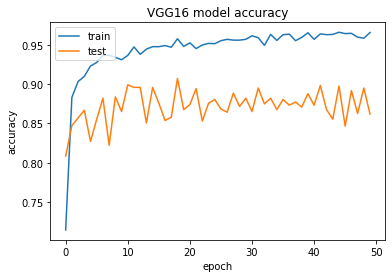

In [12]:
# VGG16 Model

VGG16_classifier=VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in VGG16_classifier.layers:
    layer.trainable=False

with tf.device('/device:GPU:0'):
  VGG16_model = tf.keras.Sequential([
                                     VGG16_classifier,
                                     MaxPooling2D(),
                                     Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  VGG16_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  VGG16_model_history = VGG16_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      verbose=1
      )
  plt.plot(VGG16_model_history.history['accuracy'])
  plt.plot(VGG16_model_history.history['val_accuracy'])
  plt.title('VGG16 model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

In [15]:
VGG16_model_history_df = pd.DataFrame(VGG16_model_history.history) 
VGG16_model_history_df.to_csv('VGG16_model.csv')

tf.keras.utils.plot_model(
    VGG16_model, to_file='VGG16_model.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

VGG16_model.save('VGG16_model.h5')

In [17]:
#ResNet50 model

ResNet50_classifier=ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in ResNet50_classifier.layers:
    layer.trainable=False

with tf.device('/device:GPU:0'):
  ResNet50_model = tf.keras.Sequential([
                                     ResNet50_classifier,
                                     MaxPooling2D(),
                                     Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  ResNet50_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  ResNet50_model_history = ResNet50_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      verbose=1
      )
  plt.plot(ResNet50_model_history.history['accuracy'])
  plt.plot(ResNet50_model_history.history['val_accuracy'])
  plt.title('ResNet50 model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

Epoch 1/50
23/23 [==============================] - 75s 3s/step - loss: 1.2085 - accuracy: 0.3311 - val_loss: 1.1976 - val_accuracy: 0.3538
Epoch 2/50
23/23 [==============================] - 74s 3s/step - loss: 1.1971 - accuracy: 0.3543 - val_loss: 1.1976 - val_accuracy: 0.3538
Epoch 3/50
23/23 [==============================] - 73s 3s/step - loss: 1.1971 - accuracy: 0.3543 - val_loss: 1.1976 - val_accuracy: 0.3538
Epoch 4/50
23/23 [==============================] - 72s 3s/step - loss: 1.1971 - accuracy: 0.3543 - val_loss: 1.1976 - val_accuracy: 0.3538
Epoch 5/50
23/23 [==============================] - 72s 3s/step - loss: 1.1971 - accuracy: 0.3543 - val_loss: 1.1976 - val_accuracy: 0.3538
Epoch 6/50
23/23 [==============================] - 72s 3s/step - loss: 1.1971 - accuracy: 0.3543 - val_loss: 1.1976 - val_accuracy: 0.3538
Epoch 7/50
23/23 [==============================] - 72s 3s/step - loss: 1.1971 - accuracy: 0.3543 - val_loss: 1.1976 - val_accuracy: 0.3538
Epoch 8/50
23/23 [==

KeyboardInterrupt: ignored

In [18]:
ResNet50_model_history_df = pd.DataFrame(ResNet50_model_history.history) 
ResNet50_model_history_df.to_csv('ResNet50_model.csv')

tf.keras.utils.plot_model(
    ResNet50_model, to_file='ResNet50_model.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

model.save('ResNet50_model.h5')

NameError: ignored